# Tuto 004 : Skyscraper protection against earthquakes and wind

This tutorial acts as a first checkpoint in the manipulation of pyHarm. The main objective of this tutorial will be the design of damping solutions for a high building. The notebook is divided into three main parts : 
1. Construction and Linear analysis of the building
2. Building response to earthquakes and tuned mass damper design
3. Building response to wind and damping with a pendulum


In [1]:
## This block makes the mandatory imports and configure matplotlib for figures
## Some help function is also define here (get_frf)
import sys
PATH_TO_PYHARM = False
PATH_TO_PYHARM = "../"
if PATH_TO_PYHARM !=False : 
    sys.path.append(PATH_TO_PYHARM)
# ------------------ IMPORTS ------------------ #
import copy
import numpy as np
import os
import matplotlib.pyplot as plt
import pyHarm
import json
import scipy.io
from pyHarm.Elements.FactoryElements import ElementDictionary
from pyHarm.Elements.ABCElement import ABCElement

# ------------------ MATPLOTLIB DEFAULT STYLE ------------------ #
plt.style.use('default')
FONT_BASE = 25
width_fig = 15
ratio_fig = (width_fig,1/(16/10.)*width_fig)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 
plt.rc('xtick', labelsize=FONT_BASE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_BASE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_BASE)    # legend fontsize
plt.rc('axes', labelsize=FONT_BASE)
plt.rc('axes', titlesize=FONT_BASE+5) #fontsize of the title

style_plots_ref = {"frf_lin":{"linestyle":"dashed","color":np.array([0,0,0]),\
                          "label":"Linear solution"},\
                   "distrib":{"linestyle":"solid","linewidth":2,"color":np.array([0,140,255])/255.,\
                           "marker":None,\
                         "label":"Spectral Density"},\
                   "frf_earthquake":{"linestyle":"solid","linewidth":2,"color":np.array([0,140,255])/255.,\
                           "marker":None,\
                         "label":"Response using earthquake \n distribution"},\
                   "frf_tuned":{"linestyle":"solid","linewidth":2,"color":np.array([255,140,0])/255.,\
                           "marker":None,\
                         "label":"Response with the tuned \n mass"},\
                   "frf_tuned_dashpot":{"linestyle":"solid","linewidth":2,"color":np.array([255,144/2.,0])/255.,\
                           "marker":None,\
                         "label":"Response with the tuned \n mass and dashpot"},\
                   "frf_wind":{"linestyle":"solid","linewidth":2,"color":np.array([144/3.,200,144/3.])/255.,\
                           "marker":None,\
                         "label":"Response using wind \n distribution"},\
                   "frf_pend":{"linestyle":"solid","linewidth":2,"color":np.array([.3,.3,.3]),\
                           "marker":None,\
                         "label":"Response with pendulum"}
                  }
SAVE = False

# ------------------ helper functions ------------------ #
def get_frf(M,indices_selection=('sub1', 0, 0),analysis="FRF"): 
    indexH = M.getIndex(*indices_selection)
    SA = [sol for sol in M.nls[analysis].SolList if sol.flag_accepted]
    om = np.array([sol.x[-1] for sol in SA])
    ampH = np.array([np.linalg.norm(sol.x[indexH]) for sol in SA])
    return SA,om,ampH


def prep_fig(fp):
    fig,ax = plt.subplots(figsize=ratio_fig)
    ax.set_yticks([])
#     ax.set_xlim(0,fp[-2]+3)
    ax.set_xscale("log")
    ax.set_xticks(fp)
    ax.set_xticklabels([f"{f:.2e}" for f in fp],rotation=90)
    ax.grid()
    return fig,ax

# 1. Construction and Linear analysis of the skyscraper
In the first part of this tutorial the focus will be put on the construction and the characteristics of the building. The building will be modeled by a serie of linear masses attached to each other through linear springs representing the different floors. The structure is modeled only as a 1 degree of freedom per mass structure, and only a transverse displacement is taken into account. 

### 1.1 Construction of the mass matrix
The first part consists in building the mass matrix of the structure. 
- Complete the function that computes the mass per floor according to the instructions given in the function description `mass_per_floor`
- Complete the function `build_mass_matrix` that builds the Mass matrix of the structure in agreement with the description of the function.

In [2]:
### ------------------ MASS MATRIX OF THE BUILDING ------------------ ###
from Tuto_004_SkyscraperEnhancement_correctionfunctions import mass_per_floor_corr, build_mass_matrix_corr
# --- Inputs of the problem
RHO_CEMENT = 2.4e3 # 2.4e3 [kg/m^3]
AREA_FLOOR = 3e2 # 3e2 [m^2]
THICKNESS_SLAB = .5 # 0.5 [m] thickness of the slab, each floor is supposed to be composed of two slabs (floor and ceiling)
GROUND_SLAB = 3. # 3. [m] thickness of the slab linked to the ground
HEIGHT_FLOOR = 4. # Total height of one floor counting the slabs

#### USER MODIFICATIONS 
def mass_per_floor(rho:float,area:float,thickness:float) -> float:
    """Function that returns the mass per floor using the mass per volume, the area of the floor and
    the thickness of the slabs. 2 slabs are present per floor"""
    mass = 0
    return mass
#### END 

mass_per_floor_value = mass_per_floor_corr(RHO_CEMENT,AREA_FLOOR,THICKNESS_SLAB)
mass_ground_value = mass_per_floor_corr(RHO_CEMENT,AREA_FLOOR,GROUND_SLAB)

# --- Build the mass matrix
N_floor = 10 # number of floors / can be modified but base value is 10
#### USER MODIFICATIONS 
def build_mass_matrix(mass_per_floor_value:float, mass_ground_value:float, N_floor:int) -> np.ndarray : 
    """Fills the function in order to return the mass matrix of the building. 
    The mass matrix shall be ordered so that the ground is the last dof in the matrix and the top floor 
    is the first dof. The slabs are also present at the ground floor.
    Use np.diag in order to generate the matrix easily."""
    M = np.diag([mass_per_floor_value]*N_floor)
    M[-1,-1] += mass_per_floor_value
    return M 
#### END

M = build_mass_matrix_corr(mass_per_floor_value,mass_ground_value,N_floor)

### 1.2 Construction of the rigidity matrix 

We want the building to have a resonance frequency around $\frac{1}{3}~Hz$ at the top floor. In order to do so, we can make the approximation of a single mass of the mass of the whole building (without the ground slab). In that case, when we add a rigidity link, the natural angular frequency of the mass shall be given by : 

$$\omega_0 = \sqrt{\frac{k}{m}}$$

- Set up the elementary rigidity such that the top floor would resonate with a period of $T=3s$

In [3]:
### ------------------ APPROXIMATION OF ELEMENTARY RIGIDITY ------------------ ###
from Tuto_004_SkyscraperEnhancement_correctionfunctions import k_approx_corr
TOP_FLOOR_RESONANCE_FREQ = 1/3.

#### USER MODIFICATIONS 
def k_approx(f:float,m:float) -> float:
    """Function that returns the value of the estimated rigidity out
    of the natural angular frequency of a single mass oscillator"""
    k = 0
    return 0
#### END 

ke = k_approx_corr(TOP_FLOOR_RESONANCE_FREQ,np.sum(M[:-1,:-1]))
print(f"Approximation of the elementary rigidity is {ke:.3e}")

Approximation of the elementary rigidity is 2.842e+07


The rigidity matrix is now built in the next block, we take as hypothesis that the ground floor had added rigidity compared to the rest of the building by having a link to the ground of $100*ke$
- Complete the function `create_K` that creates the rigidity matrix. The matrix shall be a band matrix at the end with the terms out of the diagonal being negative.

In [4]:
### ------------------ CONSTRUCTION OF RIGIDITY MATRIX ------------------ ###
from Tuto_004_SkyscraperEnhancement_correctionfunctions import create_K_corr

### USER MODIFICATIONS 
def create_K(N_floor,ke) : 
    """Creates the rigidity matrix from the number of floor and
    the elementary rigidity calculated previously"""
    K = np.diag(ke*np.ones(N_floor))
    return K
### END

K = create_K_corr(N_floor,ke)


### 1.3 Modal analysis of the linear structure

Now that a rigidity matrix and a Mass matrix is available we can proceed to the modal analysis of our building. The motion equation is given by the following equation : 

$$ (-\omega^{2} \mathbb{M} + \mathbb{K})\cdot \tilde{x} = 0$$

Multiplying by the inverse of the mass matrix, we obtain : 
$$ (\mathbb{M}^{-1} \cdot \mathbb{K} -\omega^{2}\cdot \mathbb{1})\cdot \tilde{x} = 0$$

which is the eigenvalue problem to be solved. 

- Complete the function `get_modal_analysis` in order to obtain the natural frequencies and the mode shape of the building *(use np.linalg.eig)*


In [5]:
### ------------------ MODAL ANALYSIS ------------------ ###
from Tuto_004_SkyscraperEnhancement_correctionfunctions import get_modal_analysis_corr

### USER MODIFICATIONS 
def get_modal_analysis(M:np.ndarray,K:np.ndarray) -> tuple[:np.ndarray,:np.ndarray] : 
    """Function that returns natural frequencies and 
    the mode shape based on the given mass matrix and rigidity matrix. 
    Use np.linalg.eig function in order to solve the eigenvalue problem. 
    Don't forget to transform the angular frequency into frequencies.
    You can sort out the frequencies if you want at the end, but don't forget to make the
    transformation to the columns of the mode shape as well."""
    fp = np.zeros(M.shape[0],)
    phi = np.zeros(M.shape)
    return fp,phi
### END

fp,phi = get_modal_analysis_corr(M,K)
print(fp)

[0.16498613 0.49048399 0.80267518 1.09307483 1.35376943 1.57762958
 1.97266277 1.89141235 1.75850724 7.10706068]


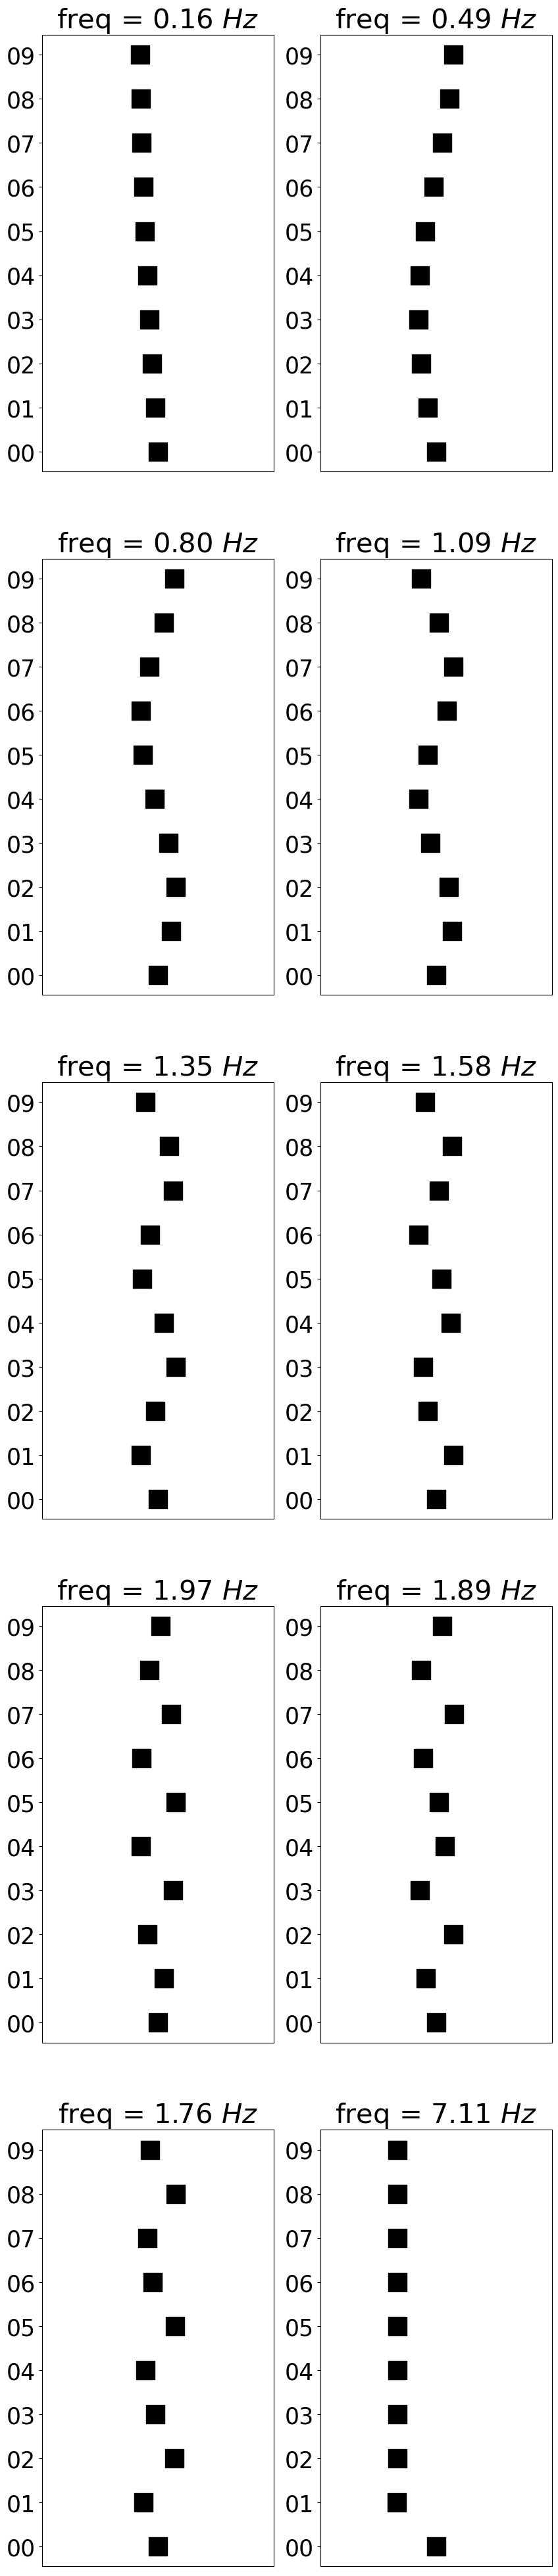

In [6]:
### This block of code is drawing the previously calculated mode shape
fig,AX = plt.subplots(N_floor//2,2,figsize=(10,10*5))
floor_numerotation = np.arange(10,0,-1)
YTICKS = [HEIGHT_FLOOR*i for i in np.arange(10,0,-1)]
for k,p in enumerate(phi.T) : 
    ax = AX[k//2,k%2]
    deformation = p - p[-1]
    ax.scatter(deformation,np.arange(10,0,-1)*HEIGHT_FLOOR,s=400,marker="s",c="k")
    ax.set_xlim(-3,3)
    ax.set_xticks([])
    ax.set_yticks(YTICKS)
    ax.set_yticklabels([f"{floor-1:02d}" for floor in floor_numerotation])
    ax.set_title(f"freq = ${fp[k]:.2f}~Hz$")

### 1.4 Construction of the damping of the structure

The structure has a natural damping present in between the floors. This will be represented by a damping matrix $\mathbb{C}$. The value of each dashpot in between the floor is set to $1e4$. Moreover, the damping at the ground floor is hundred times higher.
- Reuse the previous `create_K` function in order to create the damping matrix C

In [7]:
c_dashpot = 1e4

# ### USER MODIFICATIONS 
C = create_K_corr(N_floor,c_dashpot)
# ### END


### 1.5 Linear forced response

We can now study the system using pyHarm under a simple cosinus loading. In the next block a template of the input data is being built.
- Add a simple forcing onto the base of the skyscraper by using `CosinusForcing` connector with an amplitude of $AMP\_FORCING=5e8$.

In [8]:
from Tuto_004_SkyscraperEnhancement_correctionfunctions import add_loading_connector_corr

AMP_FORCING = 5e6

Skyscraper = dict()
Skyscraper["M"] = M
Skyscraper["C"] = C
Skyscraper["K"] = K
Skyscraper["G"] = 0 * M


# ------------------ INPUT CONSTRUCTION ------------------ #
INP = \
{
    "analysis": {"FRF":{
                "study":"frf",
                "puls_inf":(np.min(np.sort(fp[:-1])))*2*np.pi * 0.7,
                "puls_sup":(np.max(np.sort(fp[:-1])))*2*np.pi * 1.3,
                "ds_min": 1e-12,
                "ds0": 1e-2,
                "ds_max": 1e-2,
                "sign_ds": 1,
                "verbose":True,
                "solver":"scipyroot",
                "predictor":"tangent",
                "corrector":"arc_length",
                "predictor_options": {"verbose":False, "norm":"om"}
             }},
    "system":{"type":"Base",
              "nh":1,
              "nti":128,
            "adim": {"status": False,
                    "lc": 1.0,
                    "wc": 1.0}},

    "substructures": {
                "sub1": {
                    "matrix": Skyscraper,
                    "ndofs" : 1
                }
            },
    "connectors": {
        },


}

### USER MODIFICATIONS
def add_loading_connector(INP:dict,forcing_node:int, amp:float) -> dict:
    """Function that generates a new input dictionnary
    - copy the template input file
    - Add a CosinusForcing into the input file with the given amp and forcing_node"""
    INP_out = copy.deepcopy(INP)
    return INP_out
### END


INP_cosforcing = add_loading_connector_corr(INP, N_floor-1, AMP_FORCING)

The input file shall now be ready to be ran by pyHarm. In the next block, and because at low angular frequency the structure stills respond with large displacement, the "null" vector as a starting point is a bad guess and the code won't be able to converge. Another initializer is the solution of the linear system at the starting angular frequency. This is made by removing "null" as a parameter into the `Maestro.operate` method

- Run the code starting with the "null" parameter and see that the nonlinear solver is unable to converge
- Run with the null parameter but starting backward by putting `sign_ds=-1` into the `input["analysis"]["FRF"]["sign_ds"]`
- Suppress the "null" parameter and run the code forward

In [9]:
Lin_cosforcing = pyHarm.Maestro(INP_cosforcing) # Creation of the Maestro
Lin_cosforcing.operate() # 

solution converged at om=0.7256469148746791
solution converged at om=0.7356466903665375
solution converged at om=0.7456464251234781
solution converged at om=0.7556461100110714
solution converged at om=0.7656457334215815
solution converged at om=0.7756452804799192
solution converged at om=0.7856447319515605
solution converged at om=0.795644062722722
solution converged at om=0.8056432396606766
solution converged at om=0.8156422185570203
solution converged at om=0.8256409397014192
solution converged at om=0.835639321369764
solution converged at om=0.8456372500814746
solution converged at om=0.8556345657541428
solution converged at om=0.8656310386295656
solution converged at om=0.8756263326283067
solution converged at om=0.8856199457717191
solution converged at om=0.8956111108346533
solution converged at om=0.9055986251104619
solution converged at om=0.9155805501870926
solution converged at om=0.9255536665656546
solution converged at om=0.935512454467001
solution converged at om=0.94544714

solution converged at om=2.8893287963364753
solution converged at om=2.8993263172616293
solution converged at om=2.9093230694973187
solution converged at om=2.91931874980614
solution converged at om=2.9293129067641135
solution converged at om=2.939304852853051
solution converged at om=2.949293514346398
solution converged at om=2.9592771674302516
solution converged at om=2.9692529601727116
solution converged at om=2.9792160204229683
solution converged at om=2.9891577478374254
solution converged at om=2.9990624984103866
solution converged at om=3.0089012501256787
solution converged at om=3.018620529093616
solution converged at om=3.0281279651760915
solution converged at om=3.0372892264536935
solution converged at om=3.045964424674066
solution converged at om=3.054064458170501
solution converged at om=3.0615381312489833
solution converged at om=3.0682867354671917
solution converged at om=3.0740910344136436
solution converged at om=3.078632682271693
solution not accepted at om=3.0823721386

solution converged at om=5.045218664475776
solution not accepted at om=5.045467973690747
solution converged at om=5.190592170306217
solution converged at om=5.195594033329068
solution converged at om=5.200595614614055
solution converged at om=5.205596963629009
solution converged at om=5.210598120031753
solution converged at om=5.2206019388243785
solution converged at om=5.230604812525425
solution converged at om=5.240607008061119
solution converged at om=5.250608708517764
solution converged at om=5.2606100418896835
solution converged at om=5.27061109921381
solution converged at om=5.280611946264018
solution converged at om=5.290612631250495
solution converged at om=5.30061318997418
solution converged at om=5.310613649345063
solution converged at om=5.320614029816857
solution converged at om=5.330614347097177
solution converged at om=5.34061461336484
solution converged at om=5.3506148381470915
solution converged at om=5.360615028959063
solution converged at om=5.370615191774925
solution

solution converged at om=7.333931010083387
solution converged at om=7.343931030485821
solution converged at om=7.353931048821371
solution converged at om=7.36393106533215
solution converged at om=7.3739310802275835
solution converged at om=7.383931093689333
solution converged at om=7.393931105875411
solution converged at om=7.403931116923612
solution converged at om=7.4139311269544
solution converged at om=7.423931136073331
solution converged at om=7.433931144373106
solution converged at om=7.443931151935304
solution converged at om=7.453931158831863
solution converged at om=7.463931165126329
solution converged at om=7.473931170874934
solution converged at om=7.483931176127515
solution converged at om=7.493931180928301
solution converged at om=7.503931185316591
solution converged at om=7.5139311893273435
solution converged at om=7.523931192991675
solution converged at om=7.533931196337303
solution converged at om=7.543931199388918
solution converged at om=7.5539312021685205
solution co

solution converged at om=9.79955667607001
solution converged at om=9.809541746286511
solution converged at om=9.819518265543342
solution converged at om=9.829479863317891
solution converged at om=9.839414283406395
solution converged at om=9.849297149354523
solution converged at om=9.859079561656014
solution converged at om=9.868668737791136
solution converged at om=9.877920661265994
solution converged at om=9.8867031499172
solution converged at om=9.895035580183826
solution converged at om=9.903204780502893
solution converged at om=9.912063573622255
solution converged at om=9.923966714619981
solution converged at om=9.938392999767036
solution converged at om=9.950599555689202
solution converged at om=9.961527944057154
solution converged at om=9.971942218530081
solution converged at om=9.982141996382948
solution converged at om=9.99224572190403
solution converged at om=10.002303200606477
solution converged at om=10.01233688332105
solution converged at om=10.022357584515001
solution conv

solution converged at om=12.194676782760553
solution converged at om=12.204676744372362
solution converged at om=12.214676684154636
solution converged at om=12.22467659599807
solution converged at om=12.234676470648262
solution converged at om=12.24467629407121
solution converged at om=12.254676044729848
solution converged at om=12.264675688936835
solution converged at om=12.27467517269198
solution converged at om=12.284674406862601
solution converged at om=12.294673239253443
solution converged at om=12.304671399757973
solution converged at om=12.314668387724307
solution converged at om=12.324663229580487
solution converged at om=12.334653933371301
solution converged at om=12.344636221373376
solution converged at om=12.354600621445666
solution converged at om=12.364526807577644
solution converged at om=12.374380452155622
solution converged at om=12.384152966927468
solution converged at om=12.393994661691346
solution converged at om=12.404147841290316
solution converged at om=12.4144674

solution converged at om=14.504890078603362
solution converged at om=14.514890078604926
solution converged at om=14.524890078606463
solution converged at om=14.534890078607974
solution converged at om=14.544890078609455
solution converged at om=14.55489007861091
solution converged at om=14.564890078612338
solution converged at om=14.574890078613741
solution converged at om=14.58489007861512
solution converged at om=14.594890078616473
solution converged at om=14.604890078617803
solution converged at om=14.61489007861911
solution converged at om=14.624890078620394
solution converged at om=14.634890078621655
solution converged at om=14.644890078622897
solution converged at om=14.654890078624115
solution converged at om=14.664890078625312
solution converged at om=14.674890078626488
solution converged at om=14.684890078627644
solution converged at om=14.69489007862878
solution converged at om=14.704890078629898
solution converged at om=14.714890078630997
solution converged at om=14.72489007

In [10]:
# -------------------- Draw of the frf -------------------- #
SA_lin_cosforcing, om_lin_cosforcing, ampH_lin_cosforcing = get_frf(Lin_cosforcing) # from the Maestro object, we extract some FRF 

fig,ax = prep_fig(fp)
ax.plot(om_lin_cosforcing/(2*np.pi),ampH_lin_cosforcing,**style_plots_ref["frf_lin"])
ax.set_yscale("log")

## 2. Response to an earthquake and construction of a tuned mass damper

### 2.1 Modification of the forcing to comply with an earthquake spectral density

Earthquakes do not hold the same energy depending on the frequency. The usual way to describe the content of energy is the spectral density. Here we are gonna build an approximation of the spectral forcing density of an earthquake based on a distribution law 
- Complete the function that returns a normal distribution law function with given parameters 
- Make an estimation of the energy present in the previous forcing (integral over the forcing over the angular frequency) 
- Generate the spectral density of earthquake that follows a normal distribution over $log10(\omega)$ with a mean around $log10(1~Hz)$ and a standard deviation of $log10(0.5~Hz)$

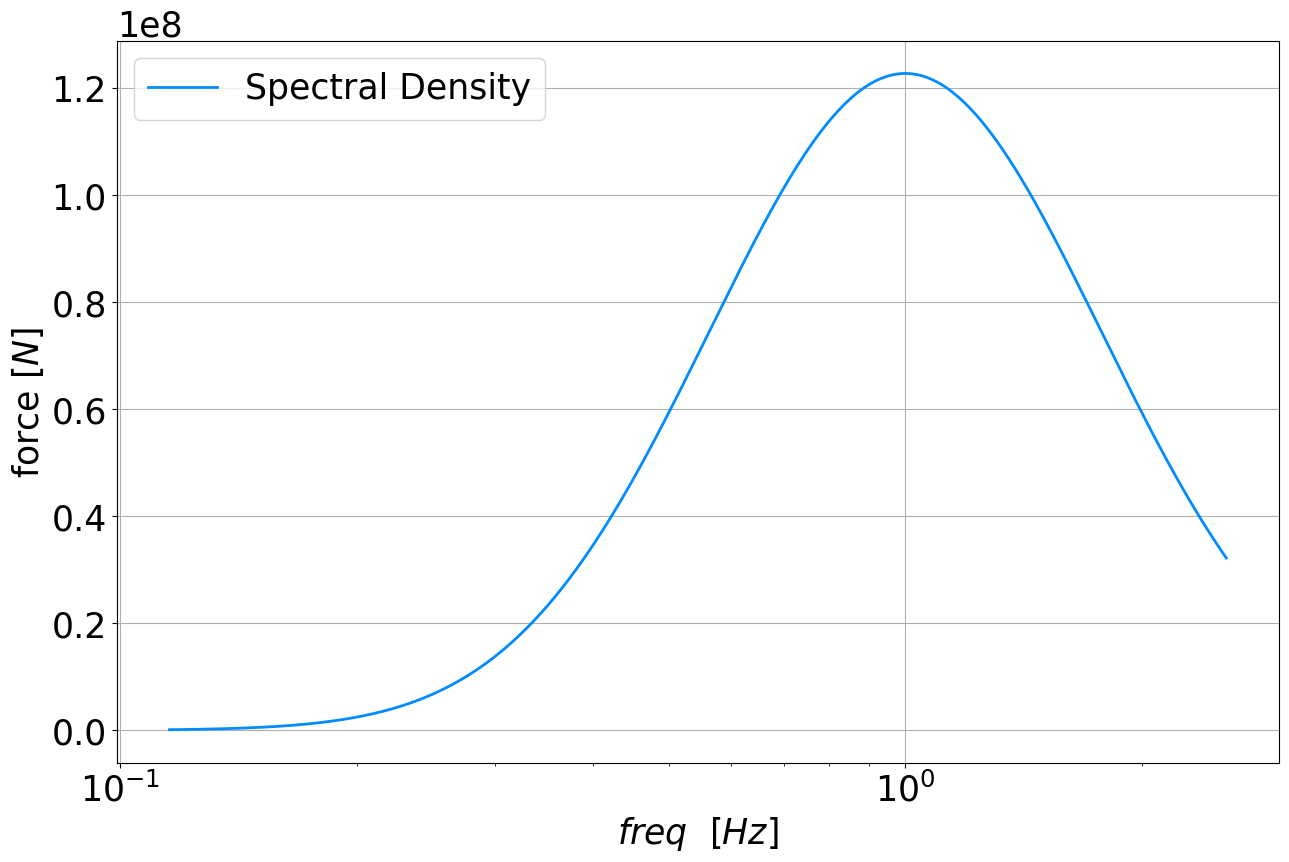

In [11]:
from Tuto_004_SkyscraperEnhancement_correctionfunctions import normal_creation_corr,estimate_energy_corr
from typing import Callable

MEAN_DISTRIB_EARTHQUAKE = 1.0
STD_DISTRIB_EARTHQUAKE = 0.5

### USER MODIFICATIONS
def normal_creation(mean:float,std:float,energy:float=1.)->Callable:
    """Function that generates a normal distribution law based on the given parameters"""
    def normal(om:np.ndarray)->np.ndarray:
        """Based on the given parameters in the normal_creation function 
        returns the distribution value"""
        f = 0
        return f 
    return normal
### END

### USER MODIFICATIONS
def estimate_energy(amp,om_min,om_max):
    """Function that estimates the energy from the previous loading."""
    E = 0
    return E
### END

om_min = INP["analysis"]["FRF"]["puls_inf"]
om_max = INP["analysis"]["FRF"]["puls_sup"]
energy = estimate_energy_corr(AMP_FORCING,om_min,om_max)


omega_ana = 10**np.linspace(np.log10(om_min),np.log10(om_max),int(1e3))
force_distribution = normal_creation_corr(MEAN_DISTRIB_EARTHQUAKE,STD_DISTRIB_EARTHQUAKE,energy) # (20,2.5,energy) is base


fig,ax = plt.subplots(figsize=ratio_fig)
ax.plot(omega_ana/(2*np.pi),force_distribution(omega_ana),**style_plots_ref["distrib"])
ax.grid()
ax.legend()
ax.set_xlabel("$freq~~[Hz]$")
ax.set_ylabel("force $[N]$")
ax.set_xscale("log")

Now that we have a distribution of force that is more representative, we will construct the equivalent forcing into pyHarm. 
- Complete the LawResidual function that returns the forcing according to the angular frequency

In [12]:
from pyHarm.Elements.FactoryElements import ElementDictionary
from pyHarm.Elements.NodeToNodeElements.NodeToNodeElement import NodeToNodeElement
from Tuto_004_SkyscraperEnhancement_correctionfunctions import LawResidual_corr
from pyHarm.BaseUtilFuncs import pyHarm_plugin

### USER MODIFICATIONS 
def LawResidual(x:np.ndarray,om:np.ndarray,loadvec:np.ndarray,law:Callable)->np.ndarray:
    R = np.zeros(x.shape)
    return R
### END 

class LawForcing(NodeToNodeElement):
    factory_keyword = "LawForcing"
    def __post_init__(self,):
        self.loadvec = self._loadingdofs()
        self.law = self.data["law"]
    def __flag_update__(self) : 
        self.flag_extforcing = True
    def _loadingdofs(self,):
        loadvec = np.zeros((2*self.nh+1,))
        loadvec[1:3] = np.array([1.,0.])
        return loadvec 
    def evalResidual(self, xg, om):
        x = xg[self.indices]
        self.R = LawResidual_corr(x,om,self._loadingdofs(),self.law) # Here to put your function
        return self.R
    def evalJacobian(self, xg, om):
        self.J,self.dJdom = self._evalJaco_DF(xg, om, 1e-5)
        return self.J,self.dJdom
    def adim(self,):
        pass

pyHarm_plugin(LawForcing)

In [13]:
from Tuto_004_SkyscraperEnhancement_correctionfunctions import add_loading_connector_law_corr

### USER MODIFICATIONS
def add_loading_connector_law(INP:dict,forcing_node:int, law:Callable) -> dict:
    """Function that generates a new input dictionnary
    - copy the template input file
    - Add a CosinusForcing into the input file with the given amp and forcing_node"""
    INP_out = copy.deepcopy(INP)
    load = {}
    INP_out["connectors"]["loading"] = load
    return INP_out
### END


INP_earthquake = add_loading_connector_law_corr(INP, N_floor-1, force_distribution)

In [14]:
Lin_earthquake = pyHarm.Maestro(INP_earthquake) # Creation of the Maestro
Lin_earthquake.operate() # 

solution converged at om=0.7256469148746791
solution converged at om=0.7356469113535783
solution converged at om=0.7456469069608367
solution converged at om=0.7556469014645942
solution converged at om=0.7656468945640265
solution converged at om=0.7756468858659107
solution converged at om=0.7856468748520489
solution converged at om=0.7956468608334607
solution converged at om=0.8056468428851743
solution converged at om=0.8156468197521486
solution converged at om=0.8256467897115625
solution converged at om=0.8356467503680175
solution converged at om=0.8456466983436546
solution converged at om=0.8556466288002593
solution converged at om=0.8656465346866421
solution converged at om=0.8756464055254402
solution converged at om=0.885646225406395
solution converged at om=0.8956459695688163
solution converged at om=0.9056455983881382
solution converged at om=0.9156450463932305
solution converged at om=0.9256442013340548
solution converged at om=0.9356428622679583
solution converged at om=0.945640

solution converged at om=2.5790954246655424
solution converged at om=2.5890928451411788
solution converged at om=2.599089997870183
solution converged at om=2.6090868487682433
solution converged at om=2.6190833586179774
solution converged at om=2.629079482176902
solution converged at om=2.6390751671102013
solution converged at om=2.6490703527101878
solution converged at om=2.659064968355181
solution converged at om=2.66905893164951
solution converged at om=2.6790521461719368
solution converged at om=2.689044498742298
solution converged at om=2.699035856094017
solution converged at om=2.709026060812423
solution converged at om=2.719014926364495
solution converged at om=2.7290022310029296
solution converged at om=2.7389877102750044
solution converged at om=2.748971047802852
solution converged at om=2.758951863925327
solution converged at om=2.7689297017025263
solution converged at om=2.778904009683435
solution converged at om=2.788874120731369
solution converged at om=2.7988392261017783
s

solution converged at om=4.417318520140111
solution converged at om=4.427315469586741
solution converged at om=4.4373121667743645
solution converged at om=4.447308586720533
solution converged at om=4.457304701523756
solution converged at om=4.467300479963174
solution converged at om=4.477295887061647
solution converged at om=4.487290883566456
solution converged at om=4.497285425355466
solution converged at om=4.507279462751441
solution converged at om=4.517272939729415
solution converged at om=4.527265792999138
solution converged at om=4.537257950941483
solution converged at om=4.547249332374164
solution converged at om=4.557239845117651
solution converged at om=4.567229384327353
solution converged at om=4.57721783055253
solution converged at om=4.587205047475705
solution converged at om=4.597190879279284
solution converged at om=4.607175147577823
solution converged at om=4.617157647845764
solution converged at om=4.627138145261273
solution converged at om=4.637116369877691
solution co

solution converged at om=6.382240011507462
solution converged at om=6.392230072358818
solution converged at om=6.402219078672734
solution converged at om=6.412206898447952
solution converged at om=6.422193380650865
solution converged at om=6.43217835219525
solution converged at om=6.4421616144184775
solution converged at om=6.452142938973169
solution converged at om=6.462122063043068
solution converged at om=6.4720986837827965
solution converged at om=6.48207245187322
solution converged at om=6.492042964079916
solution converged at om=6.5020097547038755
solution converged at om=6.511972285824792
solution converged at om=6.521929936262842
solution converged at om=6.5318819892313655
solution converged at om=6.541827618728163
solution converged at om=6.551765874825889
solution converged at om=6.5616956681823
solution converged at om=6.571615754305132
solution converged at om=6.58152471837574
solution converged at om=6.591420961749929
solution converged at om=6.601302691583374
solution con

solution converged at om=8.460785527733043
solution converged at om=8.46909867317583
solution converged at om=8.477172485474561
solution converged at om=8.484972241477484
solution converged at om=8.492515514805811
solution converged at om=8.500086098598771
solution converged at om=8.509504316526927
solution converged at om=8.530270232832674
solution converged at om=8.545357044163516
solution converged at om=8.55837898459527
solution converged at om=8.570573018993482
solution converged at om=8.582301100932922
solution converged at om=8.593722338096555
solution converged at om=8.60492111705701
solution converged at om=8.615947540150772
solution converged at om=8.626833860089183
solution converged at om=8.63760231343613
solution converged at om=8.648269273646182
solution converged at om=8.658847599000623
solution converged at om=8.66934799152332
solution converged at om=8.679779769573948
solution converged at om=8.690151281212291
solution converged at om=8.700470102273028
solution converg

solution converged at om=10.570675819509765
solution converged at om=10.58067498346695
solution converged at om=10.59067393283839
solution converged at om=10.600672649021288
solution converged at om=10.610671109363965
solution converged at om=10.620669286526589
solution converged at om=10.630667147691158
solution converged at om=10.640664653586645
solution converged at om=10.650661757286038
solution converged at om=10.660658402720005
solution converged at om=10.670654522836632
solution converged at om=10.680650037316889
solution converged at om=10.690644849721131
solution converged at om=10.700638843955009
solution converged at om=10.710631879793967
solution converged at om=10.720623787273757
solution converged at om=10.73061435959955
solution converged at om=10.740603344152548
solution converged at om=10.750590431046001
solution converged at om=10.76057523851823
solution converged at om=10.77055729424179
solution converged at om=10.780536011365802
solution converged at om=10.790510657

solution converged at om=12.73836542930167
solution converged at om=12.748366036608846
solution converged at om=12.758366566483824
solution converged at om=12.768367030664724
solution converged at om=12.778367438854383
solution converged at om=12.78836779911433
solution converged at om=12.79836811817504
solution converged at om=12.808368401681772
solution converged at om=12.818368654390472
solution converged at om=12.82836888032477
solution converged at om=12.838369082902462
solution converged at om=12.848369265037915
solution converged at om=12.85836942922539
solution converged at om=12.868369577607142
solution converged at om=12.878369712029338
solution converged at om=12.88836983408815
solution converged at om=12.89836994516793
solution converged at om=12.908370046472918
solution converged at om=12.918370139053708
solution converged at om=12.928370223829406
solution converged at om=12.938370301606234
solution converged at om=12.948370373093233
solution converged at om=12.95837043891

solution converged at om=14.678371501285053
solution converged at om=14.688371501539534
solution converged at om=14.698371501790469
solution converged at om=14.70837150203793
solution converged at om=14.718371502281988
solution converged at om=14.728371502522709
solution converged at om=14.738371502760158
solution converged at om=14.748371502994399
solution converged at om=14.758371503225495
solution converged at om=14.768371503453508
solution converged at om=14.778371503678496
solution converged at om=14.78837150390052
solution converged at om=14.798371504119633
solution converged at om=14.808371504336199
solution converged at om=14.818371504549658
solution converged at om=14.82837150476037
solution converged at om=14.838371504968386
solution converged at om=14.848371505173757
solution converged at om=14.858371505376532
solution converged at om=14.868371505576757
solution converged at om=14.87837150577448
solution converged at om=14.888371505969747
solution converged at om=14.89837150

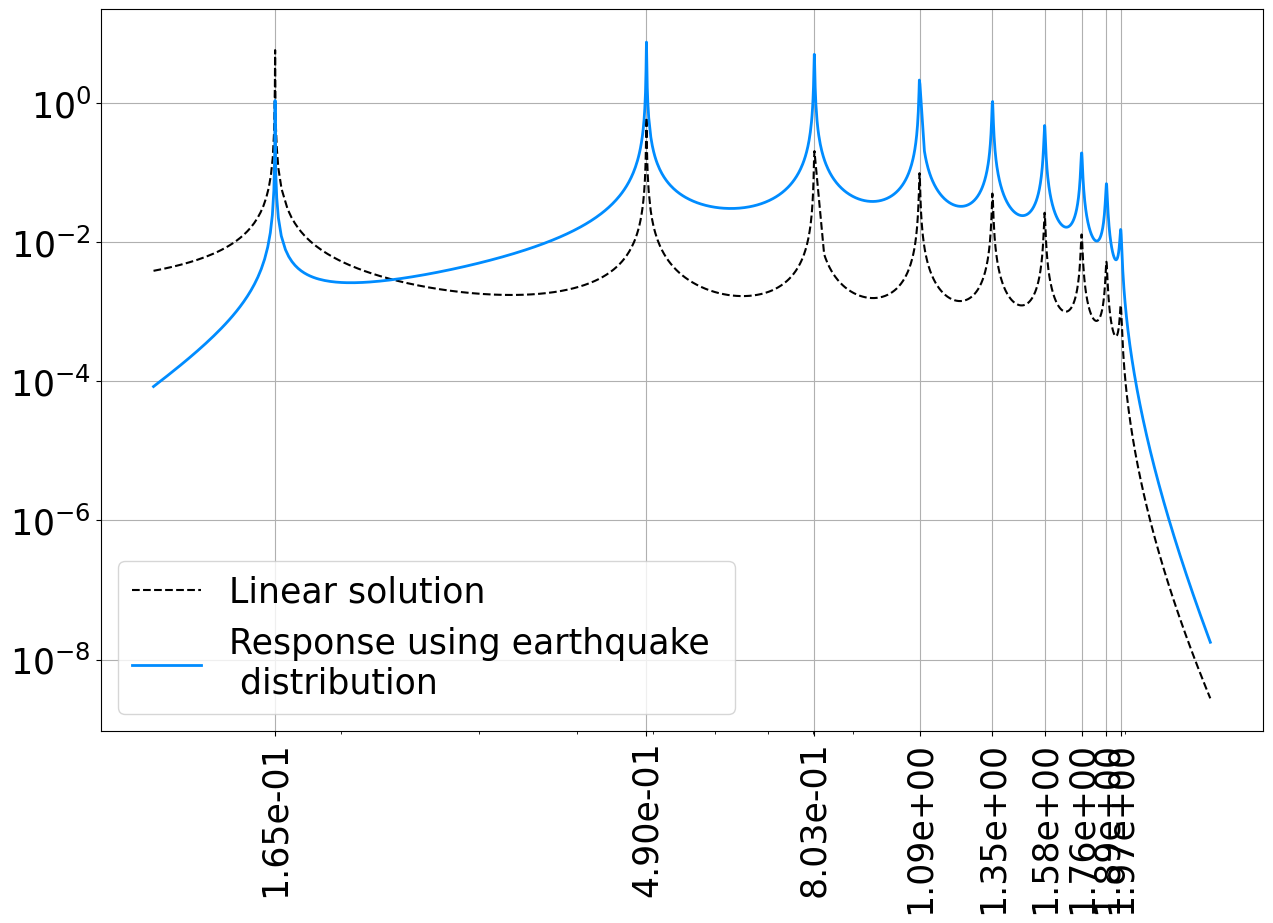

In [15]:
# -------------------- Draw of the frf -------------------- #
SA_lin_earthquake, om_lin_earthquake, ampH_lin_earthquake = get_frf(Lin_earthquake) # from the Maestro object, we extract some FRF 

fig,ax = prep_fig(fp)
ax.plot(om_lin_cosforcing/(2*np.pi),ampH_lin_cosforcing,**style_plots_ref["frf_lin"])
ax.plot(om_lin_earthquake/(2*np.pi),ampH_lin_earthquake,**style_plots_ref["frf_earthquake"])
# ax.set_ylim(1e-5,1e1)
ax.set_yscale("log")
ax.legend()

### 2.2 Tuned mass damper construction

From the previous analysis, we can see that depending on the model of the forcing, the maximum of response can change from one mode to another. In the next section, we propose to introduce a tuned mass damper at the last floor in the hope of absorbing vibration energy. 

We will first try to damp the skyscraper response by adding a mass at the top floor linked to the floor through a Linear spring and a simple dashpot. The mass on the tuned mass damper system is set to be 10 times lower than the mass of the whole last floor
- Create the new substructure (this substructure only has a mass matrix but other matrices need to be set to 0)
- Using `k_approx` function coded earlier tune the spring value to be added between the last floor and the mass so that the mass resonates at the first frequency
- Complete the function to add the tuned mass system to the input dictionary, the `LinearSpring` connector between the tuned mass and the last floor as well as focusing the resolution around the peak of max response

In [16]:
from Tuto_004_SkyscraperEnhancement_correctionfunctions import add_tunedMass_to_INP_corr


max_response_f = om_lin_earthquake[np.argmax(ampH_lin_earthquake)] / (2*np.pi)
m_damper = mass_per_floor_value * 1e-1
M_damper = np.array([[m_damper]])
tunedMass = dict()
tunedMass["M"] = M_damper
tunedMass["C"] = 0*M_damper
tunedMass["K"] = 0*M_damper
tunedMass["G"] = 0*M_damper

### USER MODIFICATIONS 
spring_value = k_approx_corr(max_response_f,m_damper)
print(f"Spring value is {spring_value:.3e}")
### END

### USER MODIFICATIONS
def add_tunedMass_to_INP(INP:dict, dict_of_matrices:dict[str,np.ndarray],
                         spring_value:float, force_distribution,
                        N_floor, tunedMass, max_response_f:float=5e-1):
    """Reuse your previous function in order to add the loading"""
    INP_new = copy.deepcopy(INP) 
    ### PUT YOUR MODIFICATIONS BELLOW 
    
    ### END
    coef_range = .5
    INP_new["analysis"]["FRF"]["puls_inf"] = (1.-coef_range)*max_response_f*(2*np.pi)
    INP_new["analysis"]["FRF"]["puls_sup"] = (1.+coef_range)*max_response_f*(2*np.pi)
    return INP_new
### END

INP_tunedMass = add_tunedMass_to_INP_corr(INP, tunedMass, spring_value, force_distribution,
                        N_floor, tunedMass, max_response_f)

Spring value is 6.838e+05


In [17]:
Lin_tuned = pyHarm.Maestro(INP_tunedMass) # Creation of the Maestro
Lin_tuned.operate() # 

solution converged at om=1.5408964784324615
solution converged at om=1.5508964574044481
solution converged at om=1.560896435634782
solution converged at om=1.5708964130895873
solution converged at om=1.5808963897330017
solution converged at om=1.5908963655270911
solution converged at om=1.6008963404317451
solution converged at om=1.610896314404556
solution converged at om=1.6208962874006803
solution converged at om=1.6308962593726841
solution converged at om=1.6408962302703718
solution converged at om=1.6508962000405965
solution converged at om=1.6608961686270525
solution converged at om=1.67089613597005
solution converged at om=1.6808961020062674
solution converged at om=1.6908960666684834
solution converged at om=1.7008960298852853
solution converged at om=1.7108959915807527
solution converged at om=1.7208959516741131
solution converged at om=1.7308959100793688
solution converged at om=1.7408958667048917
solution converged at om=1.7508958214529817
solution converged at om=1.760895774

solution converged at om=3.308176362218872
solution converged at om=3.3092436447758558
solution converged at om=3.3101054697063903
solution converged at om=3.310892334144746
solution converged at om=3.3116414373423213
solution converged at om=3.3133760683931266
solution converged at om=3.317587134343757
solution converged at om=3.3272943599163685
solution converged at om=3.3473438302653413
solution converged at om=3.360692593424477
solution converged at om=3.373010922991259
solution converged at om=3.384812400853231
solution converged at om=3.3962909067352887
solution converged at om=3.407542676894503
solution converged at om=3.4186226869367022
solution converged at om=3.429565239974389
solution converged at om=3.4403931755047514
solution converged at om=3.4511225854288723
solution converged at om=3.4617654695957745
solution converged at om=3.4723313247121954
solution converged at om=3.4828281189677637
solution converged at om=3.493262880838154
solution converged at om=3.50364203307913

In [18]:
# -------------------- Draw of the frf -------------------- #
SA_lin_tuned, om_lin_tuned, ampH_lin_tuned = get_frf(Lin_tuned) # from the Maestro object, we extract some FRF
# ampH_lin_tuned
fig,ax = prep_fig(fp)
ax.plot(om_lin_earthquake/(2*np.pi),ampH_lin_earthquake,**style_plots_ref["frf_earthquake"])
ax.plot(om_lin_tuned/(2*np.pi),ampH_lin_tuned,**style_plots_ref["frf_tuned"])
ax.set_yscale("log")
ax.set_xlim(INP_tunedMass["analysis"]["FRF"]["puls_inf"]/(2*np.pi),
            INP_tunedMass["analysis"]["FRF"]["puls_sup"]/(2*np.pi))
ax.set_ylim(np.min(ampH_lin_tuned)*1e-1,
            np.max(ampH_lin_tuned)*1e1)
ax.legend(fontsize=20)

### 2.3 Add a dashpot in between the tuned mass and the last floor to enhance the damping effect

Now that the mass is tuned to the right frequency, we can add a dashpot in between the last floor and the tuned mass. In order to explore different values and estimate the best dashpot, a meshgrid exploration will be done.
- Complete the function `add_dashpot_to_INP` that adds a dashpot into the input 

In [19]:
from Tuto_004_SkyscraperEnhancement_correctionfunctions import add_dashpot_to_INP_corr
### USER MODIFICATIONS
def add_dashpot_to_INP(INP:dict, dashpot_value:float):
    """Use LinearDamper element to add the element"""
    INP_new = copy.deepcopy(INP)
    ### PUT YOUR MODIFICATIONS BELOW
    
    ## END
    return INP_new
### END

dashpot_test = 10**np.arange(2,9).astype(float)
om_save = dict()
amp_save = dict()

for dashpot_val in dashpot_test : 
    INP_dash = add_dashpot_to_INP_corr(INP_tunedMass, dashpot_val)
    INP_dash["analysis"]["FRF"]["verbose"] = False
    Lin_dash = pyHarm.Maestro(INP_dash)
    Lin_dash.operate() # 
    print(f"Simulation with dahspot_value={dashpot_val:.1e} ended in {Lin_dash.timetosolve:.3f}s")
    SA_lin_dash, om_save[dashpot_val], amp_save[dashpot_val] = get_frf(Lin_dash)


Simulation with dahspot_value=1.0e+02 ended in 1.976s
Simulation with dahspot_value=1.0e+03 ended in 1.653s
Simulation with dahspot_value=1.0e+04 ended in 1.564s
Simulation with dahspot_value=1.0e+05 ended in 1.552s
Simulation with dahspot_value=1.0e+06 ended in 1.553s
Simulation with dahspot_value=1.0e+07 ended in 1.613s
Simulation with dahspot_value=1.0e+08 ended in 1.624s


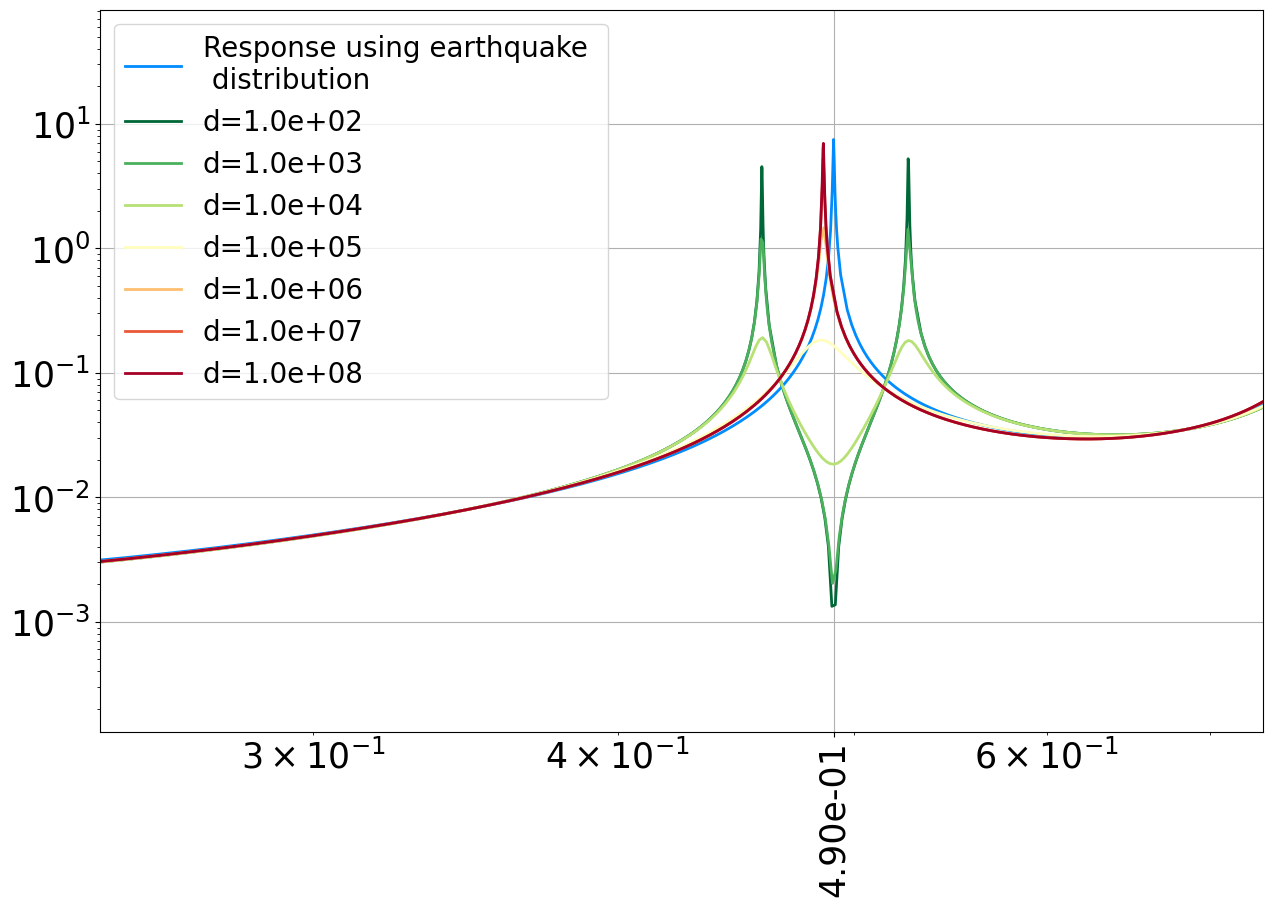

In [20]:
from matplotlib.pyplot import cm
color_param = cm.get_cmap("RdYlGn_r")(np.linspace(0,1,len(dashpot_test)))
fig,ax = prep_fig(fp)
ax.plot(om_lin_earthquake/(2*np.pi),ampH_lin_earthquake,**style_plots_ref["frf_earthquake"])
for k,dashpot_val in enumerate(dashpot_test):
    ax.plot(om_save[dashpot_val]/(2*np.pi),amp_save[dashpot_val],
            color=color_param[k,:],linewidth=2,
           label=f"d={dashpot_val:.1e}")
ax.set_xlim(INP_tunedMass["analysis"]["FRF"]["puls_inf"]/(2*np.pi),
            INP_tunedMass["analysis"]["FRF"]["puls_sup"]/(2*np.pi))
ax.set_ylim(np.min(ampH_lin_tuned)*1e-1,
            np.max(ampH_lin_tuned)*1e1)
ax.set_yscale("log")
ax.legend(fontsize=20)



### 2.4 Conclusion 

The tuned mass damper can be used to absorb energy and damp drastically the response of our building submitted to an earthquake scenario. In this section, we have seen how to customize loadings through the creation of a new element. How to add new substructures into the input dictionary and link it with existing substructure through different connectors. 

In the next section, we will push further the exercise by analysing the response of our building to a wind load that also depends on the height of the floor, all the floors being loaded by the wind. Through the use of a pendulum, we will seek to damp the movement of the building at the top floor.

## 3. Response of the structure to a wind load and damping using pendulum

Another type of load that is quite challenging for high building is the wind load onto the structure. In this section, the loading on the structure will be modified. 

### 3.1 Creation of a wind load distribution following a Weibull distribution

The wind load follows a different distribution than the earthquake load. Moreover the distribution takes into account the height as a linear form (hypothesis). Though it does not contain as much energy for the same height (for a height=1m the energy contained is 1e-6 times less than that of the earthquake)
- Complete the `weibull_creation` function in order to generate weibull distribution 


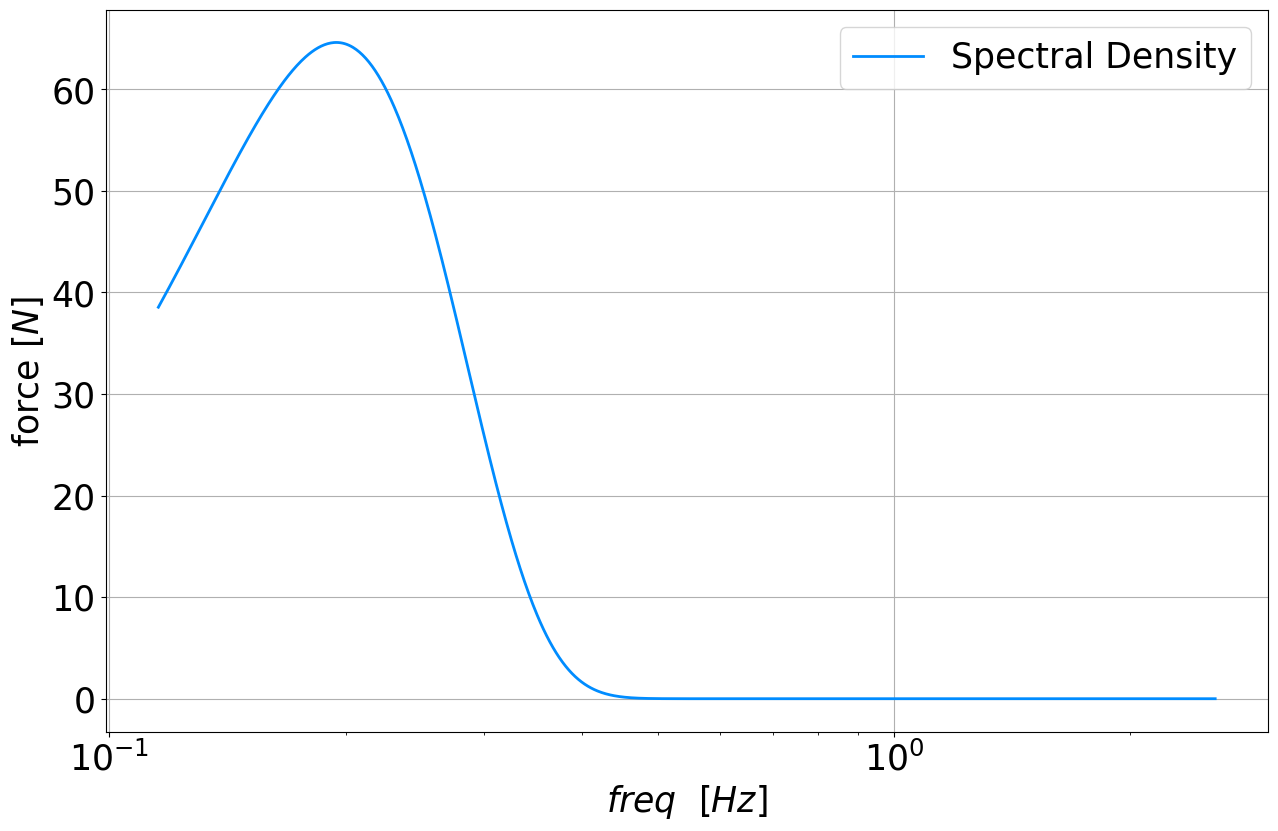

In [21]:
from Tuto_004_SkyscraperEnhancement_correctionfunctions import weibull_creation_corr

from typing import Callable

LAMBDA_WIND = 1.4 # 1.4 base
K_WIND = 3.0 # 3.0 base

### USER MODIFICATIONS
def weibull_creation(lam:float,k:float,energy:float=1.,height=1.)->Callable:
    """Function that generates a weibull distribution law based on the given parameters"""
    def weibull(om:np.ndarray)->np.ndarray:
        """Based on the given parameters in the weibull_creation function 
        returns the distribution value"""
        ### MODIFICATIONS ARE TO BE DONE BELLOW
        f = energy*(k/lam * (om/lam)**(k-1) * np.exp(-(om/lam)**(k))) # here to 
        ### END MODIFICATION
        f *= height # linear dependence of the height of the floor
        return f 
    return weibull
### END

om_min = INP["analysis"]["FRF"]["puls_inf"]
om_max = INP["analysis"]["FRF"]["puls_sup"]
energy = estimate_energy_corr(AMP_FORCING,om_min,om_max) # here to put your energy function

omega_ana = 10**np.linspace(np.log10(om_min),np.log10(om_max),int(1e3))
force_weibull = weibull_creation_corr(LAMBDA_WIND,K_WIND,energy*1e-6) # (1.4,3.0,energy*1e-6) is base --> change to your function


fig,ax = plt.subplots(figsize=ratio_fig)
ax.plot(omega_ana/(2*np.pi),force_weibull(omega_ana),**style_plots_ref["distrib"])
ax.grid()
ax.legend()
ax.set_xlabel("$freq~~[Hz]$")
ax.set_ylabel("force $[N]$")
ax.set_xscale("log")

In [22]:
from Tuto_004_SkyscraperEnhancement_correctionfunctions import add_loading_connector_law_wind_corr


### USER MODIFICATIONS
def add_loading_connector_law_wind(INP:dict,list_forcing_node_and_height:list[tuple[int,float]],
                                   law_constructor:Callable,max_response_f:float,
                                  LAMBDA_WIND,K_WIND,energy) -> dict:
    """Function that generates a new input dictionnary
    - copy the template input file
    - for each floor add a forcing generated using weibull_creation function with the right height"""
    INP_out = copy.deepcopy(INP)
    for forcing_node,height in list_forcing_node_and_height : 
        ### MODIFICATIONS ARE TO BE DONE BELLOW
        law = None
        load = {}
        ### END MODIFICATIONS
        INP_out["connectors"][f"loading_h_{height:.2e}"] = load
    coef_range = .4
    INP_out["analysis"]["FRF"]["puls_inf"] = (1.-coef_range)*max_response_f*(2*np.pi)
    INP_out["analysis"]["FRF"]["puls_sup"] = (1.+coef_range)*max_response_f*(2*np.pi)
    return INP_out
### END

list_forcing_node_and_height=[]
for k in range(N_floor):
    height = (N_floor-1-k)*HEIGHT_FLOOR
    num_floor = (N_floor-1-k)
    forcing_node_and_height = (num_floor,height)
    list_forcing_node_and_height.append(forcing_node_and_height)

INP_wind = add_loading_connector_law_wind_corr(INP, list_forcing_node_and_height, weibull_creation, fp[0], LAMBDA_WIND, K_WIND, energy)

In [23]:
Lin_wind = pyHarm.Maestro(INP_wind) # Creation of the Maestro
Lin_wind.operate() # 

solution converged at om=0.6219830698925821
solution converged at om=0.6319830507069287
solution converged at om=0.6419830292415124
solution converged at om=0.65198300514911
solution converged at om=0.661982978017509
solution converged at om=0.6719829473550528
solution converged at om=0.68198291257244
solution converged at om=0.6919828729596644
solution converged at om=0.7019828276566018
solution converged at om=0.7119827756152319
solution converged at om=0.7219827155507553
solution converged at om=0.731982645877843
solution converged at om=0.7419825646268041
solution converged at om=0.7519824693323592
solution converged at om=0.7619823568847046
solution converged at om=0.7719822233280027
solution converged at om=0.7819820635848624
solution converged at om=0.7919818710752267
solution converged at om=0.8019816371826349
solution converged at om=0.811981350496697
solution converged at om=0.8219809957223236
solution converged at om=0.8319805520843684
solution converged at om=0.841979990954

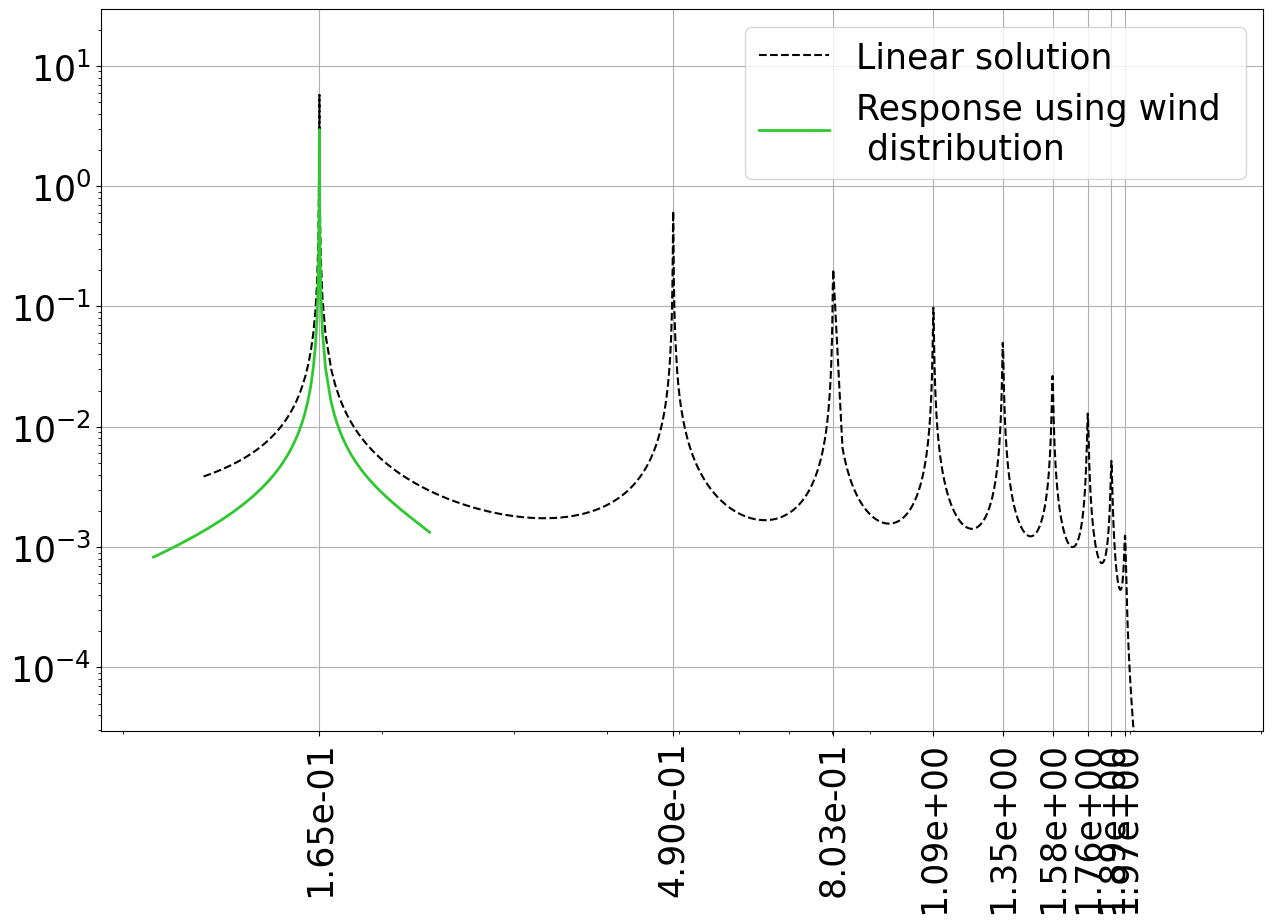

In [24]:
# -------------------- Draw of the frf -------------------- #
SA_lin_wind, om_lin_wind, ampH_lin_wind = get_frf(Lin_wind) # from the Maestro object, we extract some FRF 

fig,ax = prep_fig(fp)
ax.plot(om_lin_cosforcing/(2*np.pi),ampH_lin_cosforcing,**style_plots_ref["frf_lin"])
ax.plot(om_lin_wind/(2*np.pi),ampH_lin_wind,**style_plots_ref["frf_wind"])
# ax.set_ylim(1e-5,1e1)
ax.set_yscale("log")
ax.set_ylim(np.max(ampH_lin_wind)*1e-5,
            np.max(ampH_lin_wind)*1e1)
ax.legend()

The wind is putting under stress the first mode of the structure which could be quite uncomfortable for the inhabitants of the building as well as dangerous. In order to damp this effect of the wind the engineers have proposed to add a pendulum attached to the last floor. In the following part, we will see how to model this pendulum and try to see if the solution is quite efficient.

### 3.2 Integration of the pendulum onto the structure

The equations given here are derived from the second law of Newton. As the pendulum is attached to the top floor, the displacement of the top floor has an influence over the displacement of the pendulum. The Figure given in the next block of code gives the parametrization used for the equations. 

The position of the pendulum is given by : 
$$\begin{aligned}
x_{p} & = x \cdot \vec{e}_{x} - \cdot R \vec{e}_{r}\\
& = (-x \sin{(x)} - R) \cdot \vec{e}_{r} + (-x \cos{(\theta)}) \cdot  \vec{e}_{\theta}
\end{aligned}$$
where R is the length of the rope holding the mass of the pendulum and is considered fixed

From the position, we can derive the acceleration of the pendulum : 
$$\begin{aligned}
\frac{\partial^{2} x_{p}}{\partial t^{2}} & = (R \dot{\theta}^{2} - \ddot{x}\sin{(\theta)}) \cdot \vec{e}_{r}\\
& + (-R \ddot{\theta} - \ddot{x}\cos{(\theta)}) \cdot \vec{e}_{\theta}
\end{aligned}$$

The projection over $\vec{e}_{\theta}$ gives us the equation that rules the angle of the pendulum taking the hypothesis that $\theta<<1$ : 
$$m_{p} R \ddot{\theta} + m_{p} \ddot{x} + m_{p} g \theta = 0$$


The projection over $\vec{e}_{r}$ allows us to derive the value of the tension of the rope : 
$$T = m_{p} \cdot (R \dot{\theta}^{2} \theta - \ddot{x} \sin{(\theta)} - g \cos{(\theta)})$$

Back to the last floor, we will need the projection of the tension of the rope onto the $\vec{e}_{x}$ axis, hence multiplying the previous equation by $\sin{(\theta)}$. After using trigonometric formulas to simplify the terms and making the Taylor expansion to order 1 we obtain : 
$$T \sin{(\theta)} = m_{p} \cdot (R \dot{\theta}^{2} - g \theta)$$



(-1.0, 1.0)

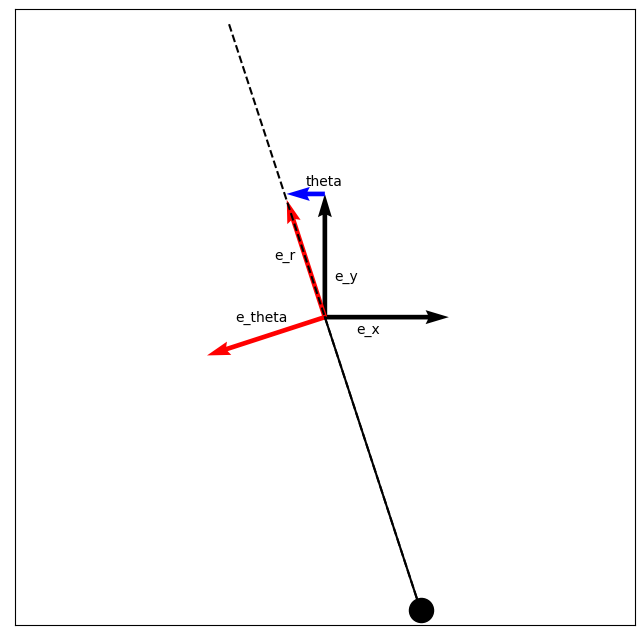

In [25]:
R = 1.
theta_ex = np.pi/10.
fig,ax = plt.subplots(figsize=(8,8))
ax.set_xticks([])
ax.set_yticks([])
ax.plot(np.array([0,R*np.sin(theta_ex)]),np.array([0,-R*np.cos(theta_ex)]),"k")
ax.plot(np.array([-R*np.sin(theta_ex),R*np.sin(theta_ex)]),np.array([R*np.cos(theta_ex),-R*np.cos(theta_ex)]),"--k")
ax.scatter(np.array([R*np.sin(theta_ex)]),np.array([-R*np.cos(theta_ex)]),s=300,c="k")

ax.quiver(0,0,.4,0,linewidth=.3,scale=1,scale_units="xy",units="xy")
ax.text(.1,-.05,"e_x")

ax.quiver(0,0,.0,.4,linewidth=.3,scale=1,scale_units="xy",units="xy")
ax.text(+.03,.12,"e_y")

ax.quiver(0,0,-.4*np.sin(theta_ex),.4*np.cos(theta_ex),linewidth=.3,scale=1,scale_units="xy",units="xy",color="r")
ax.text(-.2*np.sin(theta_ex)-.1,.2*np.cos(theta_ex),"e_r")

ax.quiver(0,0,-.4*np.cos(theta_ex),-.4*np.sin(theta_ex),linewidth=.3,scale=1,scale_units="xy",units="xy",color="r")
ax.text(-.2*np.cos(theta_ex)-.1,-.2*np.sin(theta_ex)+.05,"e_theta")


ax.quiver(0,.4,-.4*np.sin(theta_ex),0,linewidth=.3,scale=1,scale_units="xy",units="xy",color="blue")
ax.text(-.4*np.sin(theta_ex)/2.,.4+.03,"theta")




ax.set_xlim(-1,1)
ax.set_ylim(-1,1)

The next block of code implements a new element that will allow us to add all the terms that are given into the equations. The parameters of the element are explained below : 
- "dt_xo" : order of derivative for x
- "dt_to" : order of derivative for theta
- "pow_xo" : power order of the x term 
- "pow_to" : power order of the theta term
- "amp" : amplitude of the element
- "mult_theta" : is a boolean that if True multiplies the residual in the time domain by $\theta(t)$ and is used only for the $R \dot{\theta}^{2} \theta$ in the tension of the rope
- "tartine" : is used to add the residual contribution at the right place

In the time domain, the action that is made is the following : 
$$R = amp \cdot \left (\frac{\partial^{(dt\_xo)} x}{\partial t^{(dt\_xo)}}\right )^{(pow\_xo)} \cdot \left (\frac{\partial^{(dt\_to)} \theta}{\partial t^{(dt\_to)}}\right)^{(pow\_to)} \cdot \theta^{(mult\_theta)}$$

In [26]:
from pyHarm.Elements.FactoryElements import ElementDictionary
from pyHarm.Elements.NodeToNodeElements.NodeToNodeElement import NodeToNodeElement

def power_residual(x,om,nabla,deriv_xO,deriv_tethaO,
                   pow_xO,pow_tethaO,amp,
                   DFT,DTF,Pslave,Pmaster,Ptartine,
                  mult_theta=False):
    derivO_x = np.linalg.matrix_power(nabla,deriv_xO)
    derivO_theta = np.linalg.matrix_power(nabla,deriv_tethaO)
    x_t = ((derivO_x@(Pslave@x))  @  DFT)**pow_xO
    theta_brut = (Pmaster@x) @  DFT
    theta_t = ((derivO_x@(Pmaster@x))  @  DFT)**pow_tethaO
    R_t = amp * theta_t * x_t
    if mult_theta : 
        R_t *= theta_brut
    R = Ptartine.T@(R_t  @  DTF)
    return R

class PowerCustom(NodeToNodeElement):
    factory_keyword = "powcust"
    def __post_init__(self,):
        self.deriv_xO = self.data["dt_xo"]
        self.deriv_thetaO = self.data["dt_to"]
        self.pow_xO = self.data["pow_xo"]
        self.pow_tethaO = self.data["pow_to"]
        self.amp = self.data["amp"]
        self.mult_theta = self.data["mult_theta"]
    def __flag_update__(self) : 
        self.flag_AFT = True
        self.flag_nonlinear = True
    def evalResidual(self, xg, om):
        self.Pchoice = {"theta":self.Pmaster,"x":self.Pslave}
        self.tartine = self.Pchoice[self.data["tartine"]]
        x = xg[self.indices]
        self.R = power_residual(x,om,self.nabla,self.deriv_xO,self.deriv_thetaO,
                               self.pow_xO,self.pow_tethaO,self.amp,
                               self.D["ft"],self.D["tf"],self.Pslave,self.Pmaster,self.tartine)
        return self.R
    def evalJacobian(self, xg, om):
        self.J,self.dJdom = self._evalJaco_DF(xg, om, 1e-5)
        return self.J,self.dJdom
    def adim(self,):
        pass

pyHarm_plugin(PowerCustom)

We consider that the mass of the pendulum is given as 10 times less than the mass of the last floor. 
- Provide the length of the pendulum such that the pendulum matches the same frequency as the one that is aimed (first mode of vibration)

In [27]:
g = 9.81
M_PENDULUM = mass_per_floor_value * 1e-1

### USER MODIFICATIONS 
L_PENDULUM = g / ((2*np.pi*fp[0])**2)
print(f"Longueur pendule = {L_PENDULUM:.3e}")
### END

INP_pend = add_loading_connector_law_wind_corr(INP, list_forcing_node_and_height, weibull_creation, fp[0], LAMBDA_WIND, K_WIND, energy)

M_pend = np.array([[M_PENDULUM * L_PENDULUM]]) # this introduces the first term of the equation in theta
PendulumSub = dict()
PendulumSub["M"] = M_pend
PendulumSub["C"] = 0*M_pend
PendulumSub["K"] = 0*M_pend
PendulumSub["G"] = 0*M_pend



INP_pend["substructures"]["pendulum"] = {
    "matrix":PendulumSub,
    "ndofs":1
}


INP_pend["connectors"]["pend_T1"] = {
    "type":"powcust",
    "connect":{"sub1":[0],"pendulum":[0]},
    "dirs":[0],
    "dt_xo":2,
    "dt_to":0,
    "pow_xo":1.,
    "pow_to":0.,
    "amp":+1.*M_PENDULUM,
    "mult_theta":False,
    "tartine":"theta",
}

INP_pend["connectors"]["pend_T2"] = {
    "type":"powcust",
    "connect":{"sub1":[0],"pendulum":[0]},
    "dirs":[0],
    "dt_xo":0,
    "dt_to":0,
    "pow_xo":0.,
    "pow_to":1.,
    "amp":+1.*M_PENDULUM*g,
    "mult_theta":False,
    "tartine":"theta",
}

INP_pend["connectors"]["floor_T1"] = {
    "type":"powcust",
    "connect":{"sub1":[0],"pendulum":[0]},
    "dirs":[0],
    "dt_xo":0,
    "dt_to":1,
    "pow_xo":0.,
    "pow_to":2.,
    "amp":-1.*M_PENDULUM * L_PENDULUM,
    "mult_theta":True,
    "tartine":"x",
}


INP_pend["connectors"]["floor_T3"] = {
    "type":"powcust",
    "connect":{"sub1":[0],"pendulum":[0]},
    "dirs":[0],
    "dt_xo":0,
    "dt_to":0,
    "pow_xo":0.,
    "pow_to":1.,
    "amp":+1.*M_PENDULUM*g,
    "mult_theta":False,
    "tartine":"x",
}


INP_pend["analysis"]["FRF"]["ds_max"] /= 2.

Longueur pendule = 9.129e+00


In [28]:
Pendulum = pyHarm.Maestro(INP_pend)
Pendulum.operate("null")

solution converged at om=0.6219830698925821
solution converged at om=0.6269830661499558
solution converged at om=0.6319830622190583
solution converged at om=0.6369830580882395
solution converged at om=0.641983053745001
solution converged at om=0.6469830491759259
solution converged at om=0.651983044366604
solution converged at om=0.656983039301549
solution converged at om=0.6619830339641085
solution converged at om=0.6669830283363669
solution converged at om=0.6719830223990385
solution converged at om=0.6769830161313515
solution converged at om=0.6819830095109218
solution converged at om=0.6869830025136154
solution converged at om=0.6919829951133984
solution converged at om=0.6969829872821743
solution converged at om=0.7019829789896063
solution converged at om=0.7069829702029247
solution converged at om=0.7119829608867176
solution converged at om=0.7169829510027041
solution converged at om=0.7219829405094884
solution converged at om=0.7269829293622937
solution converged at om=0.73198291

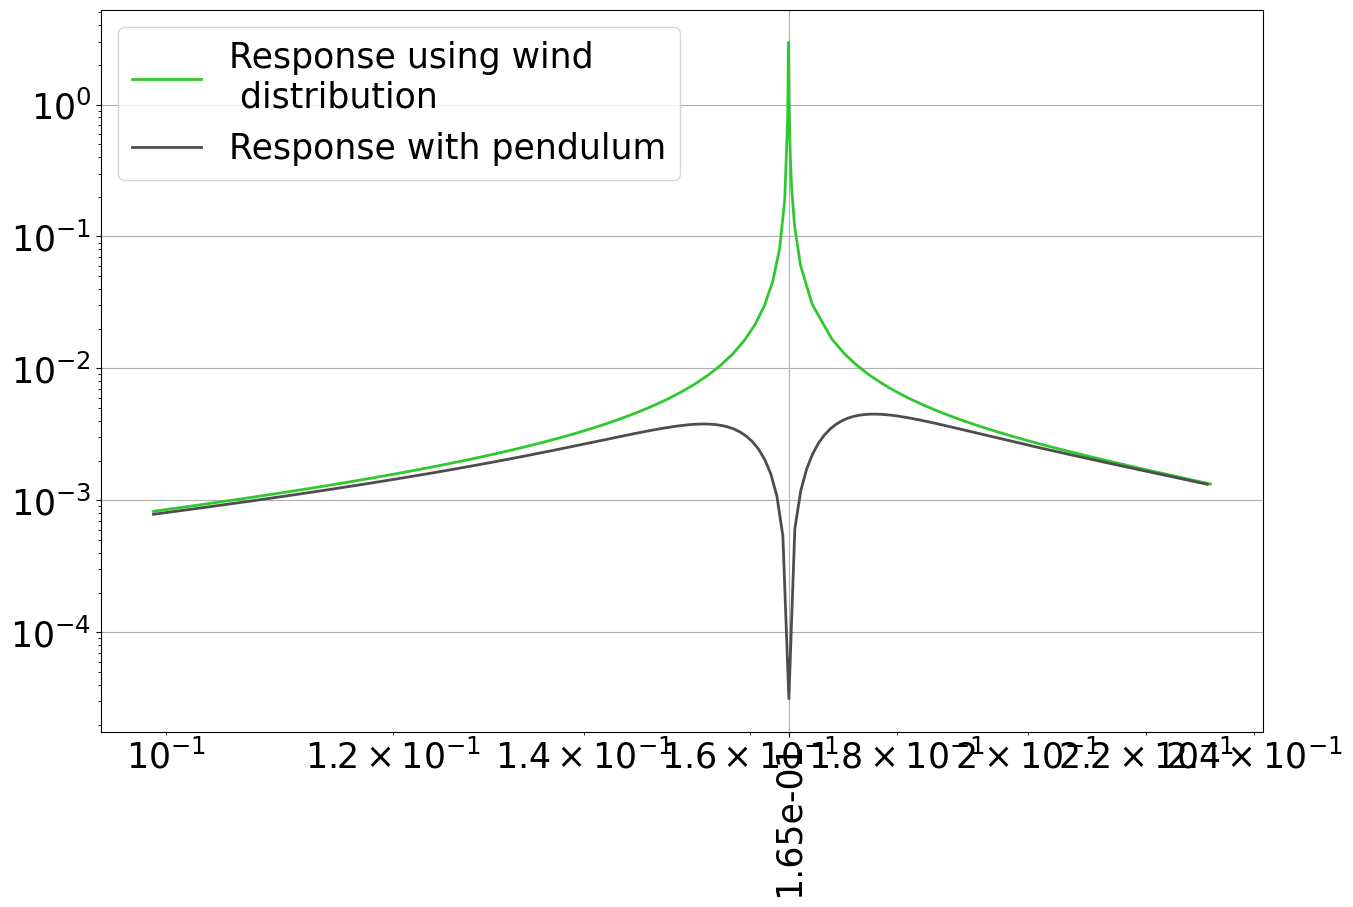

In [29]:

# -------------------- Draw of the frf -------------------- #
SA_lin_pendulum, om_lin_pendulum, ampH_lin_pendulum = get_frf(Pendulum)
fig,ax = prep_fig(fp)
ax.plot(om_lin_wind/(2*np.pi),ampH_lin_wind,**style_plots_ref["frf_wind"])
ax.plot(om_lin_pendulum/(2*np.pi),ampH_lin_pendulum,**style_plots_ref["frf_pend"])
ax.set_yscale("log")
ax.legend()


### 3.3 Conclusion 

The integration of the pendulum has allowed the building to damp its resonance when submitted to the wind. One of the main advantage of this damper is that its frequency does not depend on its mass, so any mass would be beneficial to add. Moreover the mass has quite an influence even when taking small masses. This damping solution is quite efficient as it is able to damp the building even with smaller masses compared to the mass of one floor. 

# Conclusion of the whole notebook 
Congratulations for making it to the end of this notebook that was made as a first checkpoint into the comprehension and the habits of using pyHarm and python environment. In this notebook we learnt how to construct custom loadings and went further into the modelling inside pyHarm. The next notebooks will focus on friction and its use as a damping technology. 